In [1]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="TestJob",          # --job-name
    cores=10,                     # Number of cores per task (adjust if needed)
    processes=5,                 # One process per task
    memory="40GB",               # --mem
    walltime="00:15:00",         # --time
    queue="short",               # --partition
    log_directory=".",           # Logs will be saved to the current directory
)


In [2]:
from dask.distributed import Client

cluster.scale(jobs=10)
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:8787/status,
Dashboard: http://10.42.239.61:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:35435,Workers: 0
Dashboard: http://10.42.239.61:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
# test the cluster
import dask.array as da

x = da.random.random((10000, 10000), chunks=(1000, 1000))

(x + x.T).mean().compute()




1.0000017657754605

In [5]:
import xarray as xr
import numpy as np


In [12]:
dset = xr.open_mfdataset('../Datasets/era5_manus/*.nc',
                         chunks={'time': 100, 'latitude': 10, 'longitude': 10})

hourly_summary = dset[['u','v']].isel(valid_time=slice(0,1000)).groupby('valid_time.hour').mean()

In [13]:
hourly_summary['speed'] = np.sqrt((hourly_summary['u'] * hourly_summary['u']) + (hourly_summary['v'] * hourly_summary['v']))

hourly_summary['angle'] = np.arctan(hourly_summary['v']/hourly_summary['u'])

In [14]:
final_data_loc = hourly_summary[['v','u','speed']].compute()


/home1/nalex2023/.local/lib/python3.8/site-packages/distributed/client.py:3108: UserWarning: Sending large graph of size 12.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


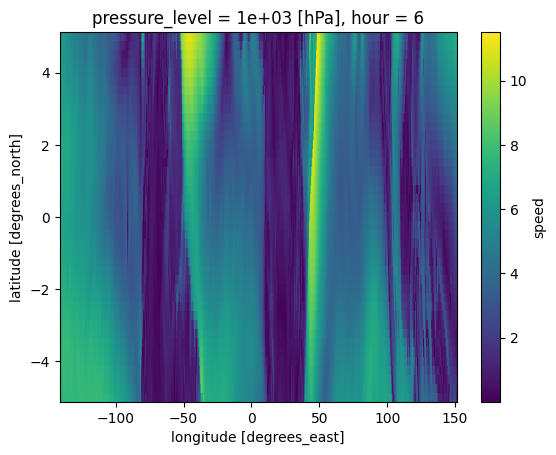

In [22]:
final_data_loc.speed.isel(hour=6,pressure_level=0).plot()